

---


***1. Régression Logistique Polytomique***


======================================================================

X_train_final shape: (537, 7)
y_train_final distribution: Counter({0: 198, 2: 145, 1: 128, 3: 66})

Class weights calculés (SMOTEENN): {np.int64(0): np.float64(0.678030303030303), np.int64(1): np.float64(1.048828125), np.int64(2): np.float64(0.9258620689655173), np.int64(3): np.float64(2.034090909090909)}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, to

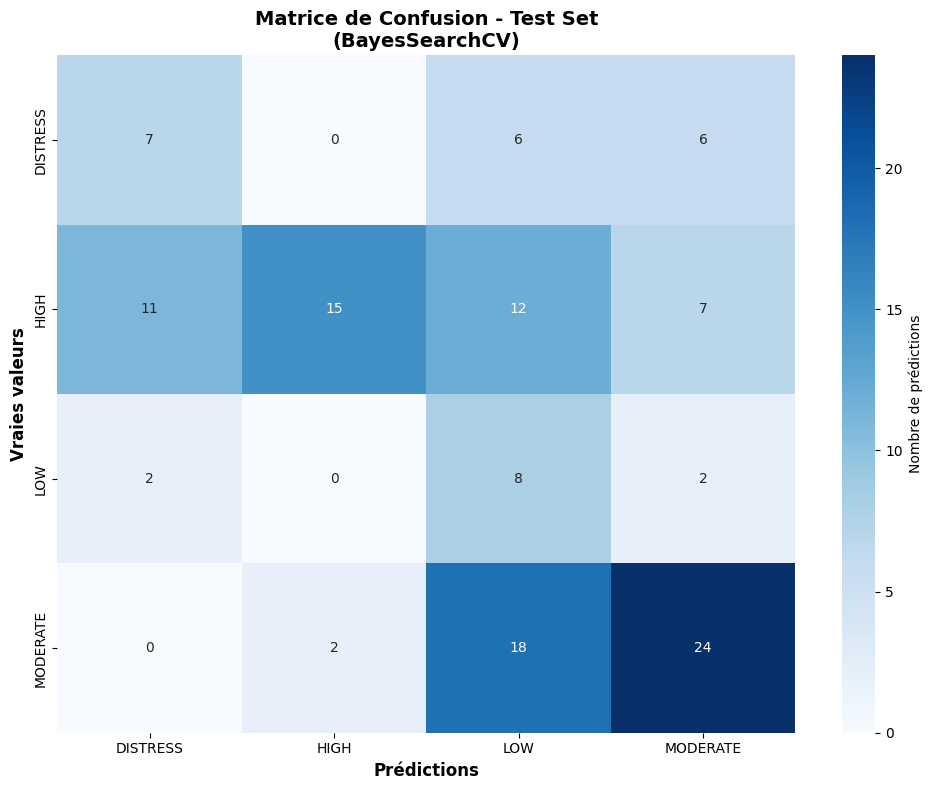


 Classe: DISTRESS
   • Vrais Positifs:  7
   • Faux Positifs:   13
   • Faux Négatifs:   12
   • Precision: 0.3500
   • Recall:    0.3684
   • F1-score:  0.3590
Recall faible (36.84%) - Le modèle rate beaucoup de cas DISTRESS!

 Classe: HIGH
   • Vrais Positifs:  15
   • Faux Positifs:   2
   • Faux Négatifs:   30
   • Precision: 0.8824
   • Recall:    0.3333
   • F1-score:  0.4839

 Classe: LOW
   • Vrais Positifs:  8
   • Faux Positifs:   36
   • Faux Négatifs:   4
   • Precision: 0.1818
   • Recall:    0.6667
   • F1-score:  0.2857

 Classe: MODERATE
   • Vrais Positifs:  24
   • Faux Positifs:   15
   • Faux Négatifs:   20
   • Precision: 0.6154
   • Recall:    0.5455
   • F1-score:  0.5783
DISTRESS            : AUC = 0.6003
HIGH                : AUC = 0.6530
LOW                 : AUC = 0.7230
MODERATE            : AUC = 0.6531


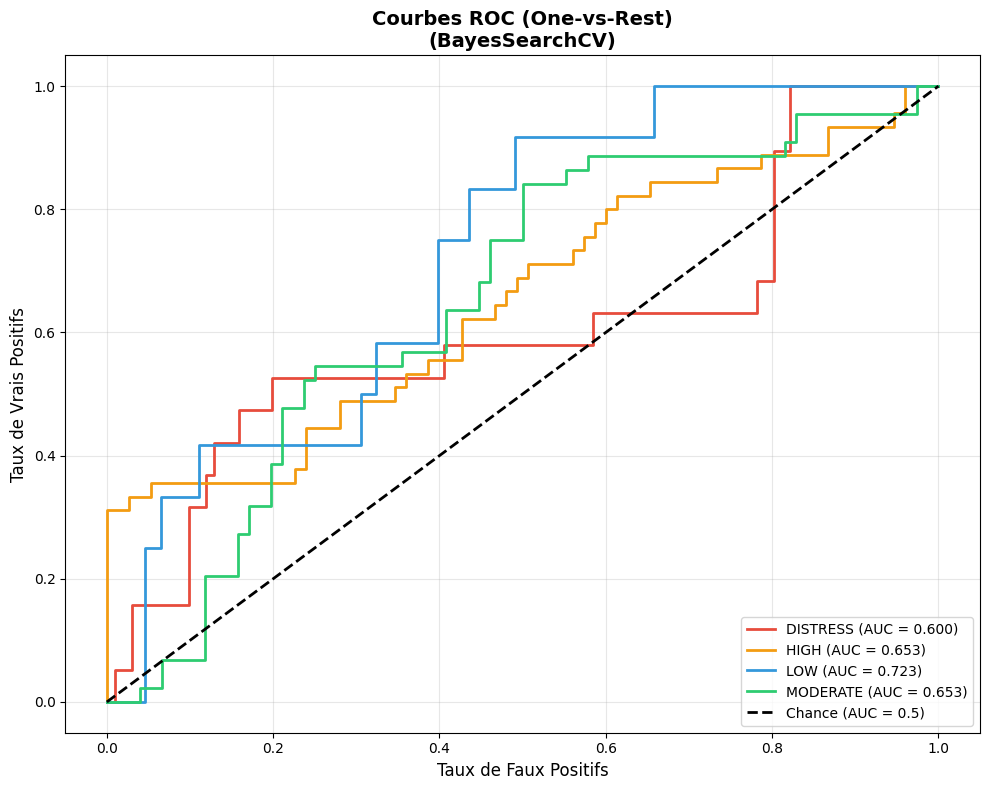


 DISTRESS:
              Feature  Coefficient
        Exchange_Rate     0.694303
    External_Debt_GDP     0.546153
Corruption_Governance    -0.440211
           GDP_Growth    -0.155663
     Net_ODA_received    -0.033129
 Debt_Service_Exports     0.000000
      Current_Account     0.000000

 HIGH:
              Feature  Coefficient
     Net_ODA_received     0.846309
           GDP_Growth    -0.228202
    External_Debt_GDP     0.183709
      Current_Account     0.082685
 Debt_Service_Exports     0.000000
        Exchange_Rate     0.000000
Corruption_Governance     0.000000

 LOW:
              Feature  Coefficient
    External_Debt_GDP    -0.649120
     Net_ODA_received    -0.238695
           GDP_Growth     0.214444
 Debt_Service_Exports    -0.149549
      Current_Account     0.000000
        Exchange_Rate     0.000000
Corruption_Governance     0.000000

 MODERATE:
              Feature  Coefficient
      Current_Account    -0.700167
           GDP_Growth     0.175937
    External_Deb

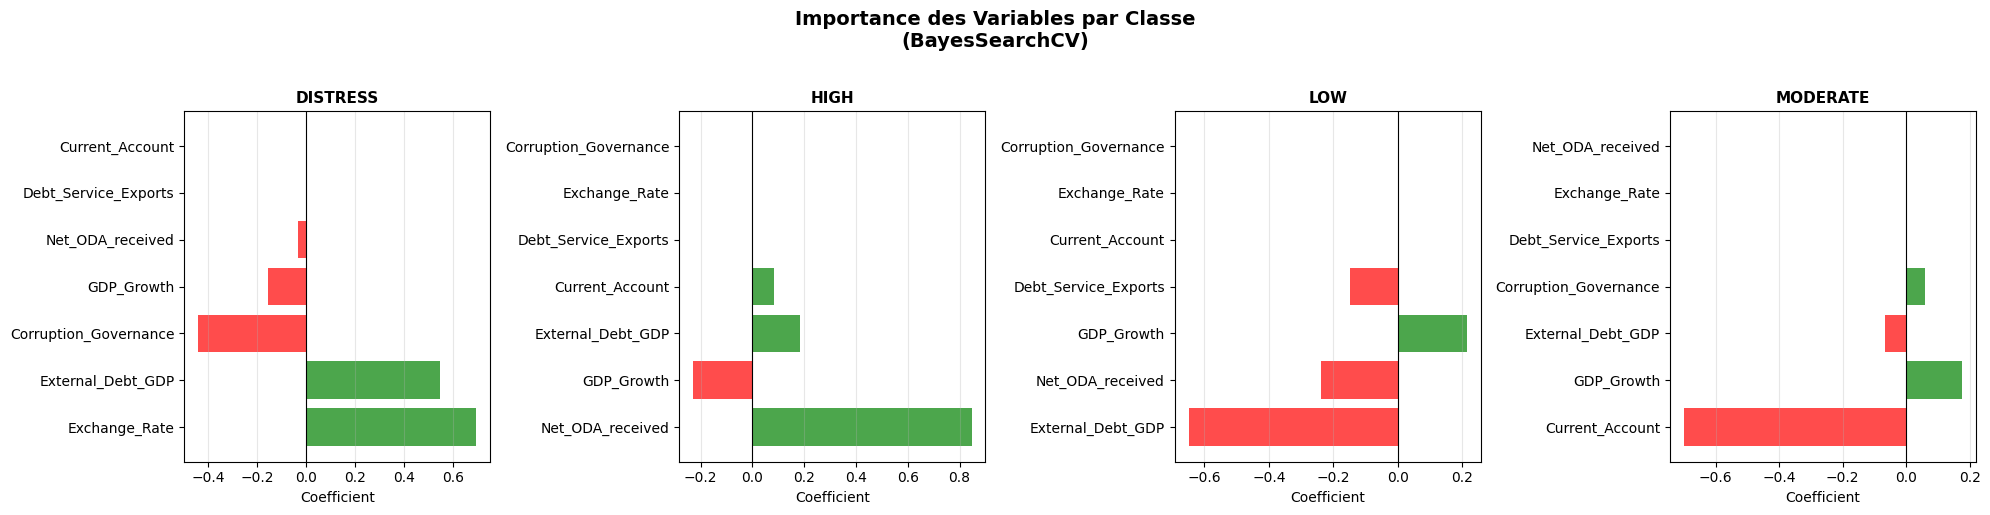

In [ ]:
search_spaces = {
    'C': Real(0.001, 100, prior='log-uniform'),
    'penalty': Categorical(['l1', 'l2', 'elasticnet']),
    'l1_ratio': Real(0.0, 1.0),
    'solver': Categorical(['saga']),
    'max_iter': Integer(100, 1000),
    'class_weight': Categorical(['balanced', None])
}

scoring_metric = 'recall_macro'
n_iter = 50
cv_folds = 5

cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"X_train_final shape: {X_train_final.shape}")
print(f"y_train_final distribution: {Counter(y_train_final)}")
print(f"\nClass weights calculés (SMOTEENN): {class_weight_dict}")

base_model = LogisticRegression(random_state=42, warm_start=True)

bayes_search = BayesSearchCV(
    estimator=base_model,
    search_spaces=search_spaces,
    n_iter=n_iter,
    cv=cv_strategy,
    scoring=scoring_metric,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    return_train_score=True
)

bayes_search.fit(X_train_final, y_train_final)

print(f"\n Meilleur score (CV {scoring_metric}): {bayes_search.best_score_:.4f}")
print(f"\n Meilleurs hyperparamètres trouvés:")
for param, value in bayes_search.best_params_.items():
    print(f"{param:15s}: {value}")



best_params = bayes_search.best_params_.copy()
best_params['class_weight'] = class_weight_dict

model_with_custom_weights = LogisticRegression(**best_params, random_state=42)
model_with_custom_weights.fit(X_train_final, y_train_final)


y_pred_bayes = bayes_search.best_estimator_.predict(X_test_final)
y_pred_proba_bayes = bayes_search.best_estimator_.predict_proba(X_test_final)
recall_bayes = recall_score(y_test_final, y_pred_bayes, average='macro')
f1_bayes = f1_score(y_test_final, y_pred_bayes, average='macro')
print(f"   • Recall macro: {recall_bayes:.4f}")
print(f"   • F1 macro:     {f1_bayes:.4f}")
print(f"   • Accuracy:     {accuracy_score(y_test_final, y_pred_bayes):.4f}")

y_pred_custom = model_with_custom_weights.predict(X_test_final)
y_pred_proba_custom = model_with_custom_weights.predict_proba(X_test_final)
recall_custom = recall_score(y_test_final, y_pred_custom, average='macro')
f1_custom = f1_score(y_test_final, y_pred_custom, average='macro')
print(f"   • Recall macro: {recall_custom:.4f}")
print(f"   • F1 macro:     {f1_custom:.4f}")
print(f"   • Accuracy:     {accuracy_score(y_test_final, y_pred_custom):.4f}")

if recall_custom > recall_bayes:
    best_model = model_with_custom_weights
    y_pred = y_pred_custom
    y_pred_proba = y_pred_proba_custom
    model_type = "Poids personnalisés (SMOTEENN)"
else:
    best_model = bayes_search.best_estimator_
    y_pred = y_pred_bayes
    y_pred_proba = y_pred_proba_bayes
    model_type = "BayesSearchCV"

y_test_labels = label_encoder.inverse_transform(y_test_final)
y_pred_labels = label_encoder.inverse_transform(y_pred)


print(f"   • Accuracy:          {accuracy_score(y_test_final, y_pred):.4f}")
print(f"   • Precision (macro): {precision_score(y_test_final, y_pred, average='macro'):.4f}")
print(f"   • Recall (macro):    {recall_score(y_test_final, y_pred, average='macro'):.4f}")
print(f"   • F1-score (macro):  {f1_score(y_test_final, y_pred, average='macro'):.4f}")


cm = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Nombre de prédictions'},
            ax=ax)
ax.set_xlabel('Prédictions', fontsize=12, fontweight='bold')
ax.set_ylabel('Vraies valeurs', fontsize=12, fontweight='bold')
ax.set_title(f'Matrice de Confusion - Test Set\n({model_type})',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


for i, class_name in enumerate(label_encoder.classes_):
    class_mask_true = (y_test_final == i)
    class_mask_pred = (y_pred == i)

    tp = np.sum(class_mask_true & class_mask_pred)
    fp = np.sum(~class_mask_true & class_mask_pred)
    fn = np.sum(class_mask_true & ~class_mask_pred)
    tn = np.sum(~class_mask_true & ~class_mask_pred)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n Classe: {class_name}")
    print(f"   • Vrais Positifs:  {tp}")
    print(f"   • Faux Positifs:   {fp}")
    print(f"   • Faux Négatifs:   {fn}")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall:    {recall:.4f}")
    print(f"   • F1-score:  {f1:.4f}")

    if class_name == 'DISTRESS':
        if recall < 0.7:
            print(f"Recall faible ({recall:.2%}) - Le modèle rate beaucoup de cas DISTRESS!")
        else:
            print(f"Recall acceptable ({recall:.2%})")


y_test_bin = label_binarize(y_test_final, classes=range(len(label_encoder.classes_)))
n_classes = len(label_encoder.classes_)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']

for i, (class_name, color) in enumerate(zip(label_encoder.classes_, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])

    ax.plot(fpr, tpr, color=color, lw=2,
            label=f'{class_name} (AUC = {roc_auc:.3f})')

    print(f"{class_name:20s}: AUC = {roc_auc:.4f}")

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance (AUC = 0.5)')
ax.set_xlabel('Taux de Faux Positifs', fontsize=12)
ax.set_ylabel('Taux de Vrais Positifs', fontsize=12)
ax.set_title(f'Courbes ROC (One-vs-Rest)\n({model_type})',
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


coefficients = best_model.coef_

fig, axes = plt.subplots(1, n_classes, figsize=(20, 5))
if n_classes == 1:
    axes = [axes]

for i, (class_name, ax) in enumerate(zip(label_encoder.classes_, axes)):
    coef_df = pd.DataFrame({
        'Feature': X_train_final.columns,
        'Coefficient': coefficients[i]
    }).sort_values('Coefficient', key=abs, ascending=False)

    print(f"\n {class_name}:")
    print(coef_df.to_string(index=False))

    colors_bar = ['red' if x < 0 else 'green' for x in coef_df['Coefficient']]
    ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors_bar, alpha=0.7)
    ax.set_xlabel('Coefficient', fontsize=10)
    ax.set_title(f'{class_name}', fontsize=11, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

plt.suptitle(f'Importance des Variables par Classe\n({model_type})',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

======================================================================